In [1]:
# Get electron microscopy dataset (https://www.epfl.ch/labs/cvlab/data/data-em/)
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Get custom packages from Github (by yingkaisha)

https://github.com/yingkaisha/keras-unet-collection/tree/main/keras_unet_collection

In [3]:
! git clone https://github.com/yingkaisha/keras-unet-collection.git
os.chdir('/content/keras-unet-collection')
from keras_unet_collection import models, losses
os.chdir('/content')
print("Current working directory", os.getcwd())

Cloning into 'keras-unet-collection'...
remote: Enumerating objects: 902, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 902 (delta 194), reused 163 (delta 161), pack-reused 688
Receiving objects: 100% (902/902), 1.03 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (609/609), done.
Current working directory /content


In [4]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

#! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
#! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-10-31 18:49:04--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12205 (12K) [text/plain]
Saving to: ‘vision.py’

vision.py           100%[===================>]  11.92K  --.-KB/s    in 0.001s  

2023-10-31 18:49:04 (17.8 MB/s) - ‘vision.py’ saved [12205/12205]

--2023-10-31 18:49:04--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9733 (9.5K) [text/plain]
S

In [5]:
#from utils.losses import dice_coef, jacard_coef, jacard_coef_loss, dice_coef_loss
#from utils.models import UNet, Attention_UNet, Attention_ResUNet
from utils import utils
from utils import vision

In [6]:
! pip install -q kaggle

#from google.colab import files
# files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/cancer-instance-segmentation-and-classification-2

 99% 693M/697M [00:08<00:00, 107MB/s]
100% 697M/697M [00:08<00:00, 90.9MB/s]


In [7]:
utils.unzip_data('/content/cancer-instance-segmentation-and-classification-2.zip')

In [8]:
IMGS_PATH = '/content/Images/images.npy'
MASKS_PATH = '/content/Masks/masks.npy'

In [9]:
img_array = np.load(IMGS_PATH, mmap_mode='r')
mask_array = np.load(MASKS_PATH, mmap_mode='r')

In [10]:
print("Number of images: ", len(img_array))
print("Number of masks: ", len(mask_array))

Number of images:  2523
Number of masks:  2523


In [11]:
from sklearn.model_selection import train_test_split

# Use only first 600 images due to memory overflow
X_train, X_test, y_train, y_test = train_test_split(img_array[:600], mask_array[:600], test_size = 0.10, random_state = 0)

In [12]:
def visualize_mask_data(dataset, ix):
  #fig = plt.figure(figsize=(10, 10))

  for index in range(y_train.shape[-1]):
      plt.subplot(2, 3, index + 1)
      plt.imshow(dataset[ix, :, :, (index-1)])
      plt.axis('off')

  plt.show()

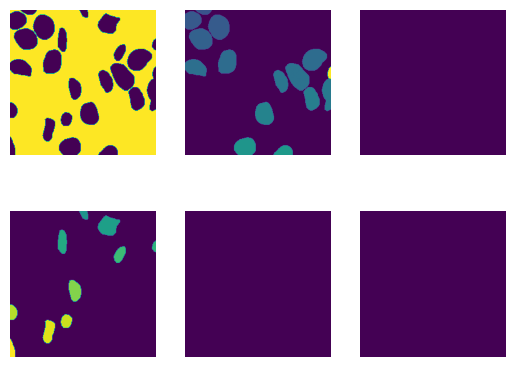

In [13]:
visualize_mask_data(y_train, 0)

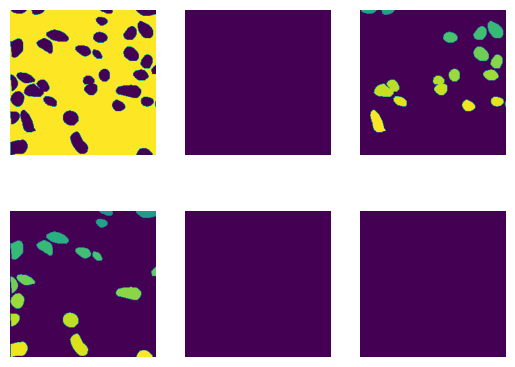

In [14]:
visualize_mask_data(y_train, 2)

We will only use last (5) channel masks for binary mask creation

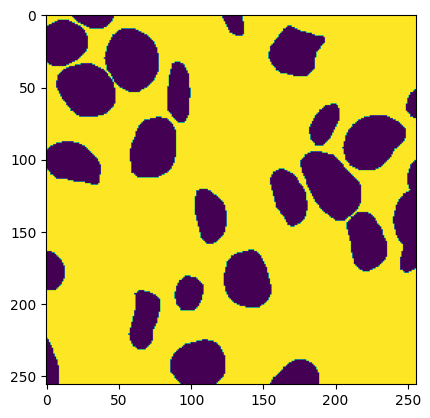

In [15]:
plt.imshow(y_train[0,:,:,5])

In [16]:
y_train = y_train[:,:,:,5]  # Mask array shape (60, 256, 256, 6), convert it to the (60, 256, 256, 1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = y_test[:,:,:,5]  # Mask array shape (60, 256, 256, 6), convert it to the (60, 256, 256, 1)
y_test = tf.expand_dims(y_test, axis=-1)

print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (540, 256, 256, 3)
X_test.shape:  (60, 256, 256, 3)
y_train.shape:  (540, 256, 256, 1)
y_test.shape:  (60, 256, 256, 1)


In [17]:
print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')
print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

X_train min: 0.0, X_train max: 255.0, X_test min: 0.0, X_test max: 255.0
y_train min: 0.0, y_train max: 1.0, y_test min: 0.0, y_test max: 1.0


We need to normalize/scale Mask images into [0,1]

In [18]:
normalize = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

y_train = normalize(y_train)
y_test = normalize(y_test)

print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

y_train min: 0.0, y_train max: 1.0, y_test min: 0.0, y_test max: 1.0


Normalize train and test images

In [19]:
X_train = normalize(X_train)
X_test = normalize(X_test)

print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')

X_train min: 0.0, X_train max: 1.0, X_test min: 0.0, X_test max: 1.0


Convert RGB mask images to binary mask images

In [20]:
def rgb_to_gray(images):
  return np.dot(images[..., :3], [0.299, 0.587, 0.114])

In [21]:
def convert_rgb_to_binary_mask(images):
  #images = tf.image.rgb_to_grayscale(images).numpy()  # or use rgb_to_gray(images)
  if type(images) != np.ndarray:
    images = images.numpy()
  images[images > 0.0] = 1.0
  return images

In [22]:
y_train = convert_rgb_to_binary_mask(y_train)
y_test = convert_rgb_to_binary_mask(y_test)

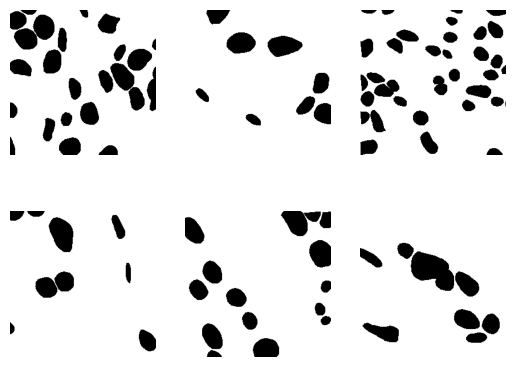

In [23]:
for ix, image in enumerate(y_train[:6]):
    plt.subplot(2, 3, ix + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

We need to invert binary mask

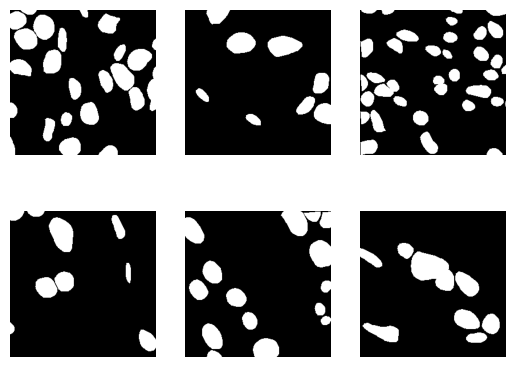

In [24]:
y_train = np.invert(y_train.astype(int))
y_test = np.invert(y_test.astype(int))

for ix, image in enumerate(y_train[:6]):
    plt.subplot(2, 3, ix + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

In [25]:
INPUT_SHAPE = (256, 256, 3)
NUM_LABELS = 1  #Binary
BATCH_SIZE = 8
EPOCHS = 50

FILTER_NUM = 64   # number of filters for the conv layer
FILTER_SIZE = 3   # size of the convolutional filter (3,3)
UP_SAMP_SIZE = 2  # size of upsampling filters

In [26]:
def create_dataset_pipeline(tensor, batch_size, shuffle=False):
    # Read images from directory and reshape, scale
    dataset = tf.data.Dataset.from_tensor_slices(tensor)

    # Shuffle (only training set) and create batches
    if shuffle == True:
        dataset = dataset.shuffle(len(tensor))
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [27]:
X_train_data = create_dataset_pipeline(X_train, BATCH_SIZE)
X_test_data = create_dataset_pipeline(X_test, BATCH_SIZE)
y_train_data = create_dataset_pipeline(y_train, BATCH_SIZE)
y_test_data = create_dataset_pipeline(y_test, BATCH_SIZE)

In [28]:
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of X_train_data batches: {len(X_train_data)}")
print(f"Number of X_test_data batches: {len(X_test_data)}")
print(f"Number of y_train_data batches: {len(y_train_data)}")
print(f"Number of y_test_data batches: {len(y_test_data)}")

Batch Size: 8
Number of X_train_data batches: 68
Number of X_test_data batches: 8
Number of y_train_data batches: 68
Number of y_test_data batches: 8


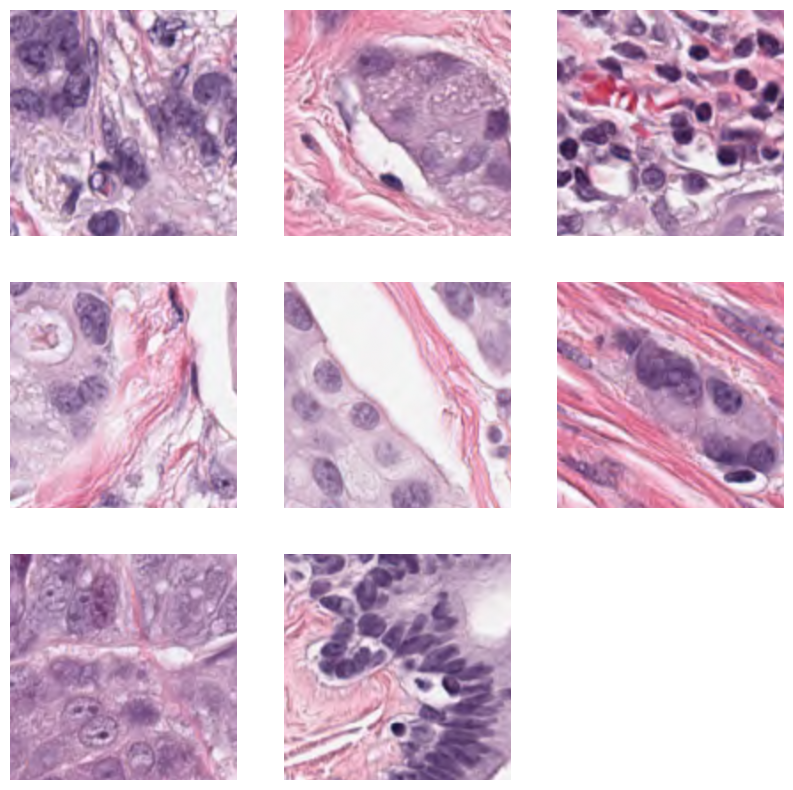

In [29]:
vision.show_image_samples_from_batch(X_train_data, grid=(3,3))

### Training U-Net Model

Unet with ImageNet trained VGG16 backbone

In [30]:
help(models.unet_2d)

Help on function unet_2d in module keras_unet_collection._model_unet_2d:

unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_s

In [31]:
model_unet = models.unet_2d((224, 224, 3), filter_num=[64, 128, 256, 512, 1024],
                           n_labels=NUM_LABELS,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU',
                           output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='unet')

/content/keras-unet-collection/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 [==============================] - 0s 0us/step


In [32]:
model_unet.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 VGG16_backbone (Functional  [(None, 224, 224, 64),       1471468   ['input_1[0][0]']             
 )                            (None, 112, 112, 128),      8                                       
                              (None, 56, 56, 256),                                                
                              (None, 28, 28, 512),                                                
                              (None, 14, 14, 512)]                                                
                                                                                         

In [33]:
model_unet.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy', losses.dice_coef])
# tf.keras.losses.BinaryFocalCrossentropy(gamma=2)

### Resize images to VGG16 input size

In [34]:
def resize_img_arrays(dataset, img_size):
  img_list = []
  for image in dataset:
    img = tf.image.resize(image, size = img_size, preserve_aspect_ratio=False)
    img_list.append(img)
  return np.array(img_list)

In [35]:
X_train = resize_img_arrays(X_train, (224, 224))
X_test = resize_img_arrays(X_test, (224, 224))
y_train = resize_img_arrays(y_train, (224, 224))
y_test = resize_img_arrays(y_test, (224, 224))

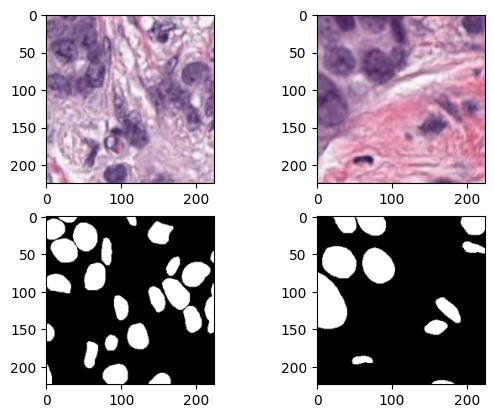

In [36]:
plt.subplot(2,2,1)
plt.imshow(X_train[0])
plt.subplot(2,2,2)
plt.imshow(X_test[0])
plt.subplot(2,2,3)
plt.imshow(y_train[0], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(y_test[0], cmap='gray')

In [37]:
import datetime

start = datetime.datetime.now()

unet_model_hist = model_unet.fit(X_train, y_train,
                                  verbose=1, batch_size=BATCH_SIZE,
                                  validation_data=(X_test, y_test), shuffle=False,
                                  epochs=EPOCHS)
end = datetime.datetime.now()
model_unet.save('cancer_instance_seg_att_res_unet_50_epochs.hdf5')
print(f"U-Net training time: {end-start}")

Epoch 1/50
68/68 [==============================] - 62s 511ms/step - loss: -6.4295 - accuracy: 0.0000e+00 - dice_coef: 0.1781 - val_loss: 840.4332 - val_accuracy: 0.0000e+00 - val_dice_coef: 3.5806
Epoch 2/50
68/68 [==============================] - 29s 434ms/step - loss: -12.1516 - accuracy: 0.0000e+00 - dice_coef: 0.0274 - val_loss: -12.8088 - val_accuracy: 0.0000e+00 - val_dice_coef: 0.0386
Epoch 3/50
68/68 [==============================] - 30s 441ms/step - loss: -18.4716 - accuracy: 0.0000e+00 - dice_coef: 0.0097 - val_loss: -19.8247 - val_accuracy: 0.0000e+00 - val_dice_coef: 0.0089
Epoch 4/50
68/68 [==============================] - 28s 412ms/step - loss: -26.2871 - accuracy: 0.0000e+00 - dice_coef: 0.0037 - val_loss: -29.1448 - val_accuracy: 0.0000e+00 - val_dice_coef: 0.0012
Epoch 5/50
68/68 [==============================] - 29s 433ms/step - loss: -35.7772 - accuracy: 0.0000e+00 - dice_coef: 0.0011 - val_loss: -41.4113 - val_accuracy: 0.0000e+00 - val_dice_coef: 2.1392e-04
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


U-Net training time: 0:24:26.992181


In [38]:
import pandas as pd

att_unet_model_hist_df = pd.DataFrame(unet_model_hist.history)

with open('att_unet_model_hist_df.csv', mode='w') as f:
    att_unet_model_hist_df.to_csv(f)

### Plot the training and validation accuracy and loss at each epoch

In [41]:
def plot_loss_curves(history):
  fig = plt.figure(figsize=(10,10))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['dice_coef']
  val_acc = history.history['val_dice_coef']

  epochs = range(1, len(loss) + 1)

  # Training and Validation Loss Graph
  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Jacard Loss Graph
  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'y', label='Training Jacard')
  plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
  plt.title('Training and validation Jacard')
  plt.xlabel('Epochs')
  plt.ylabel('Jacard')
  plt.legend()

  plt.show()

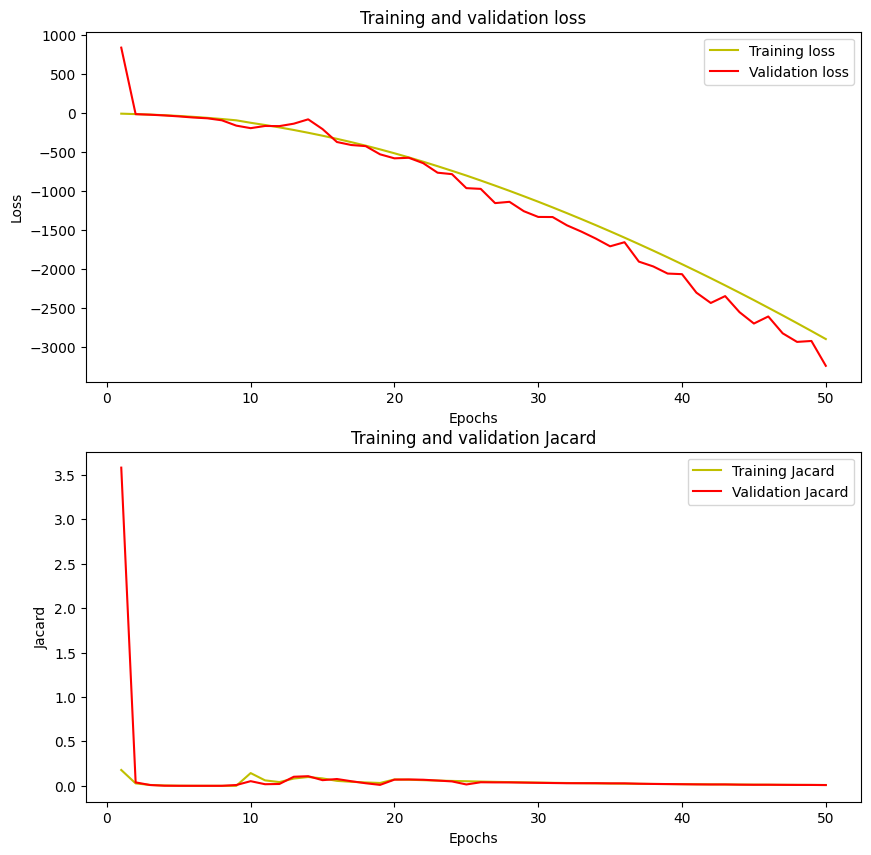

In [42]:
plot_loss_curves(unet_model_hist)

In [43]:
MODEL_PATH = '/content/cancer_instance_seg_att_res_unet_50_epochs.hdf5'

In [44]:
# Load the model for testing
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

In [45]:
TEST_IMG_IX = 2

In [46]:
test_img = X_test[TEST_IMG_IX]
ground_truth_mask = y_test[TEST_IMG_IX]

test_img_input=np.expand_dims(test_img, 0)
prediction_mask = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 2s 2s/step


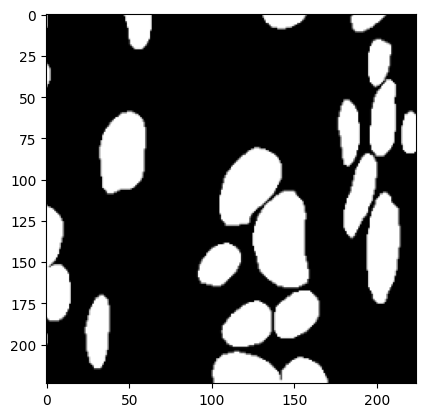

In [47]:
plt.imshow(y_test[3,:, :,0], cmap='gray')

In [48]:
def show_prediction_masks():
  ix = 0

  plt.figure(figsize=(12, 10))
  while ix < 9:
    plt.subplot(3, 3, (ix+1))
    plt.title('Testing Image')
    plt.imshow(X_test[ix], cmap='gray')

    plt.subplot(3, 3, (ix+2))
    plt.title('Testing Label')
    plt.imshow(y_test[ix,:, :,0], cmap='gray')

    plt.subplot(3, 3, (ix+3))
    plt.title('Prediction on test image')
    plt.imshow((model.predict(np.expand_dims(X_test[ix], 0))[0,:,:,0] > 0.5).astype(np.uint8), cmap='gray')

    ix = (ix+3)

  plt.show()

1/1 [==============================] - 0s 19ms/step


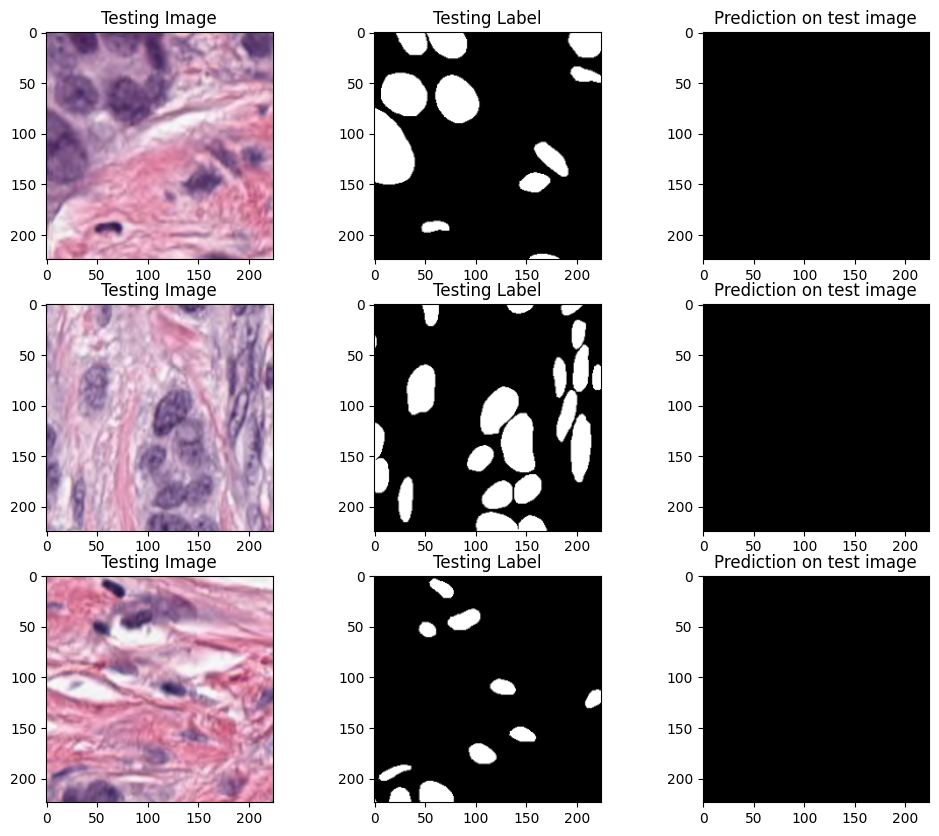

In [49]:
show_prediction_masks()

### IoU (Intersection over Union) Calculation for single test image

In [ ]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth_mask[:,:,0], prediction_mask)

print("Mean IoU =", IOU_keras.result().numpy())

### Calculate IoU for all test images and calculate Avg. IoU

In [ ]:
import pandas as pd

def calculate_IoU_of_test_dataset(model, X_test, y_test, n_classes=2):
  IoU_values = []

  for ix, test_img in enumerate(X_test):
    ground_truth = y_test[ix]
    temp_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)
    #print(IoU)

  df = pd.DataFrame(IoU_values, columns=["IoU"])
  #df = df[df.IoU != 1.0]
  mean_IoU = df.mean().values
  print("Mean IoU is: ", str(mean_IoU))

In [ ]:
calculate_IoU_of_test_dataset(model_unet, X_test, y_test)

### Reference

Original Paper: [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/pdf/1804.03999.pdf)

https://github.com/yingkaisha/keras-unet-collection

https://github.com/bnsreenu/python_for_microscopists

https://github.com/bnsreenu/python_for_microscopists/blob/master/224_225_226_models.py

[224 - Recurrent and Residual U-net](https://www.youtube.com/watch?v=7aDOtKN2cJs) by DigitalSreeni

[225 - Attention U-net. What is attention and why is it needed for U-Net? ](https://www.youtube.com/watch?v=KOF38xAvo8I) by DigitalSreeni

[226 - U-Net vs Attention U-Net vs Attention Residual U-Net - should you care? ](https://www.youtube.com/watch?v=L5iV5BHkMzM) by DigitalSreeni